In [1]:
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.constants import k as k_B  # Boltzmann constant in J/K
from scipy.constants import G, proton_mass
from functools import partial
# from lab_functions_1 import Ax, vcgrab, Tc, Lambdacalc, dLdTfunc, dVcdrfunc
import lab_functions_1 as lf

In [2]:
import importlib
import lab_functions_1  # import the full module
importlib.reload(lab_functions_1)  # reload to pick up any recent changes

# Now import the specific functions from the freshly reloaded module
import lab_functions_1 as lf

In [3]:
mp_g = proton_mass*1e3
k_Bcgs = k_B*1e7
mu = 0.6
gamma = 5/3
ktc = 3.0857e21
epsilon = 1e-3
def quadsolver(T):
    dLdT = lf.dLdTfunc(T)
    dVcdr = lf.dVcdrfunc(1*ktc, 27.1*ktc, 210*ktc)
    beta = (-5/12) + (1/6)*dLdT
    delta = (1/3)*dVcdr - 0.25
    discrim = (beta**2) - (4*delta)
    if discrim < 0:
        print("Discriminant is negative, returning NaN")
        return np.nan

    i = -beta + np.sqrt(discrim)
    j = -beta - np.sqrt(discrim)

    dlnT1 = i/2
    dlnT2 = j/2

    T1 = T*(1 + epsilon*dlnT1)
    V_base = np.sqrt(gamma * k_Bcgs * T / (mu * mp_g))
    dlnv1 = (-3/2)*dlnT1 + 3 - (2.5 * T1 / lf.Tc(ktc, 27.1*ktc, 210*ktc))
    V1 = V_base*(1 + epsilon*dlnv1)
    mach1 = V1 / np.sqrt(gamma * k_Bcgs * T1 / (mu * mp_g))

    T2 = T*(1 + epsilon*dlnT2)
    dlnv2 = (-3/2)*dlnT2 + 3 - (2.5 * T2 / lf.Tc(ktc, 27.1*ktc, 210*ktc))
    V2 = V_base*(1 + epsilon*dlnv2)
    mach2 = V2 / np.sqrt(gamma * k_Bcgs * T2 / (mu * mp_g))

    # Pick root that yields smaller Mach number
    if mach1 < mach2:
        Tnaught, vnaught = T1, V1
        machnaught = mach1
        dlnT = dlnT1
        dlnv = dlnv1
    else:
        Tnaught, vnaught = T2, V2
        machnaught = mach2
        dlnT = dlnT2
        dlnv = dlnv2

    rho1 = (3 * (mu**2) * (mp_g**2) * (lf.vcgrab(1*ktc, 27.1*ktc, 210*ktc)**3)) / (2 * lf.Lambdacalc(Tnaught) * ktc)
    Rnaught = ktc * (1 + epsilon)
    rhonaught = rho1 * (1 + epsilon * (-2 - dlnv))

    Mdot = 4 * np.pi * (Rnaught**2) * rhonaught * vnaught
    cs_naught = np.sqrt(gamma * k_Bcgs * Tnaught / (mu * mp_g))

    return Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, Mdot
print(quadsolver(820000))

(np.float64(820671.40788219), np.float64(13702456.329895806), 3.0887856999999996e+21, np.float64(1.8975846198493472e-26), np.float64(13717537.295598662), np.float64(0.998900606910856), np.float64(3.1173459298502984e+25))


C:\Users\Jacob\AppData\Local\Temp\ipykernel_11992\2347904372.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


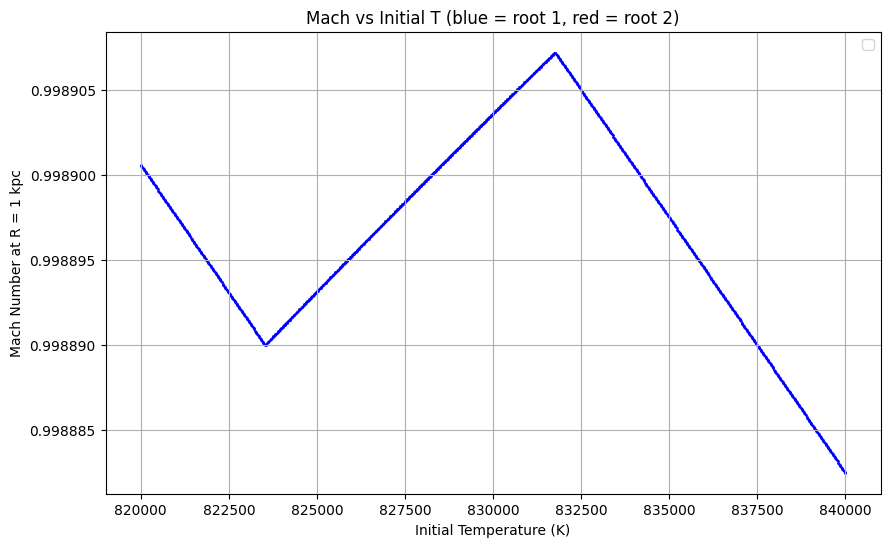

In [4]:
T_vals = np.linspace(8.2e5, 8.4e5, 1000)
mach_list = []
mach1_list = []
mach2_list = []
T_used = []
chosen_root = []

for T_try in T_vals:
    Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, Mdot = quadsolver(T_try)
    mach_list.append(machnaught)
    T_used.append(Tnaught)
    
    # Recompute both roots
    dLdT = lf.dLdTfunc(T_try)
    dVcdr = lf.dVcdrfunc(1*ktc, 27.1*ktc, 210*ktc)
    beta = (-5/12) + (1/6)*dLdT
    delta = (1/3)*dVcdr - 0.25
    discrim = (beta**2) - (4*delta)
    i = -beta + np.sqrt(discrim)
    j = -beta - np.sqrt(discrim)
    dlnT1 = i/2
    dlnT2 = j/2

    T1 = T_try * (1 + epsilon * dlnT1)
    T2 = T_try * (1 + epsilon * dlnT2)
    V_base = np.sqrt(gamma * k_Bcgs * T_try / (mu * mp_g))
    dlnv1 = (-3/2)*dlnT1 + 3 - (2.5 * T1 / lf.Tc(ktc, 27.1*ktc, 210*ktc))
    dlnv2 = (-3/2)*dlnT2 + 3 - (2.5 * T2 / lf.Tc(ktc, 27.1*ktc, 210*ktc))
    V1 = V_base * (1 + epsilon*dlnv1)
    V2 = V_base * (1 + epsilon*dlnv2)
    mach1 = V1 / np.sqrt(gamma * k_Bcgs * T1 / (mu * mp_g))
    mach2 = V2 / np.sqrt(gamma * k_Bcgs * T2 / (mu * mp_g))

    mach1_list.append(mach1)
    mach2_list.append(mach2)

    if mach1 < mach2:
        chosen_root.append(1)
    else:
        chosen_root.append(2)

# Plotting
plt.figure(figsize=(10,6))

# Both root curves
#plt.plot(T_vals, mach1_list, 'b', label='Mach (root 1)')
#plt.plot(T_vals, mach2_list, 'r', label='Mach (root 2)')

# Chosen root (dot at actual mach)
for T_try, mach_val, root in zip(T_vals, mach_list, chosen_root):
    if root == 1:
        plt.scatter(T_try, mach_val, color='blue', s=1)
    else:
        plt.scatter(T_try, mach_val, color='red', s=1)

plt.xlabel('Initial Temperature (K)')
plt.ylabel('Mach Number at R = 1 kpc')
plt.title('Mach vs Initial T (blue = root 1, red = root 2)')
plt.grid(True)
plt.legend()
plt.show()

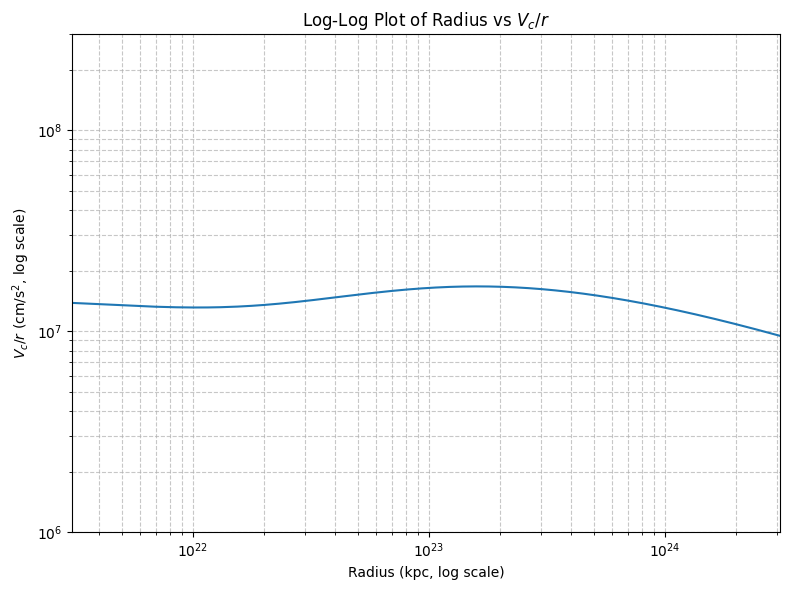

In [5]:
def vc2grab(r,rs,R):
    vc2 = lf.vcgrab(r, rs,R)**2
    return vc2/r #cm/s^2

radii = np.linspace(0.01*ktc, 1000*ktc, 4000)
vc_squared = [lf.vcgrab(r, 27.1*ktc, 210*ktc) for r in radii]

# Plotting
plt.figure(figsize=(8, 6))
plt.loglog(radii, vc_squared)
plt.xlabel("Radius (kpc, log scale)")
plt.ylabel(r"$V_c/r$ (cm/s$^2$, log scale)")
plt.title("Log-Log Plot of Radius vs $V_c/r$")
plt.xlim(3.085e21, 3.086e24)
plt.yscale('log')
plt.ylim(1e6, 3e8)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plot.png', transparent=True)
plt.show()

In [6]:
from scipy.integrate import cumulative_trapezoid

r_grid = np.linspace(ktc, 1000000 * ktc, 5000000)  # finer grid = better accuracy
vc2_over_r = np.array([vc2grab(r, 27.1 * ktc, 210 * ktc) for r in r_grid])

phi_cumint = cumulative_trapezoid(vc2_over_r, r_grid, initial=0.0)

phi_values = -(phi_cumint[-1] - phi_cumint)

phi_interp = interp1d(r_grid, phi_values, kind='cubic', fill_value="extrapolate")

def phi(r):
    """Interpolated gravitational potential at any r."""
    return phi_interp(r)


In [7]:
r_test = 500 * ktc
print(f"Phi({r_test}) = {phi(r_test)}")

Phi(1.54285e+24) = -199895839423435.2


In [8]:
def TheBigOne(r, C, Mdot):
    v, T = C
    T = np.clip(T, 1.585e4, 1.445e8)
    vc2 = (lf.vcgrab(r,27.1*ktc,210*ktc)**2)
    cs2 = (gamma*k_Bcgs*T)/(mu*mp_g)
    tflow = r/np.abs(v)
    mach = (v)/np.sqrt(cs2)
    Lambda = lf.Lambdacalc(T)
    rho = Mdot/(4*np.pi*(r**2)*v)
    n = rho/(mu*mp_g)
    tcool = (3*k_Bcgs*T)/(2*Lambda*n)
    #Bern = (v**2 / 2) + (cs2*3/2) + phi(r)
    denominator = mach**2 - 1.0
    if abs(denominator) < 1e-6:
        dlnvdlnr = 1e10 * np.sign(denominator)
    else:
        dlnvdlnr = (2 - (vc2 / cs2) - (tflow / (gamma * tcool))) / denominator
    dlnTdlnr = (-2/3)*(dlnvdlnr + 5*(lf.Tc(r,27.1*ktc,210*ktc))/(2*T) - 3)
    dvdr = (v/r)*dlnvdlnr
    dTdr = (T/r)*dlnTdlnr
    return [dvdr, dTdr]

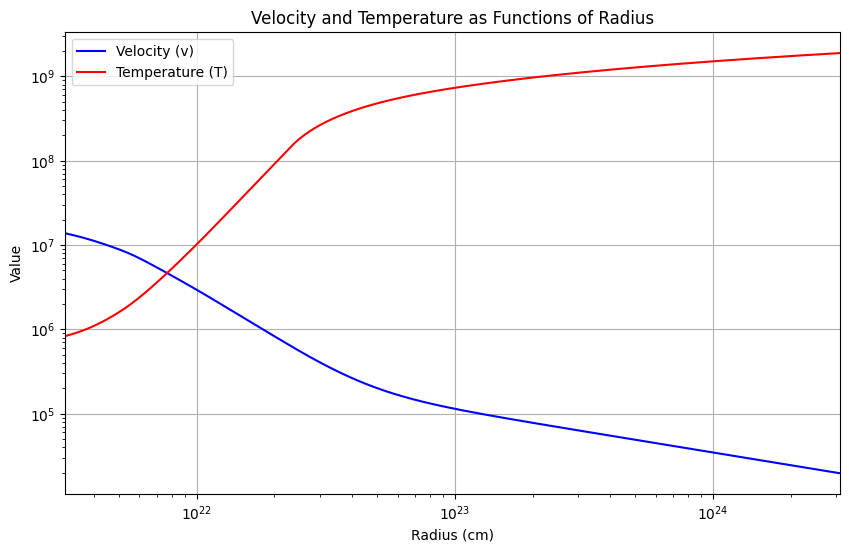

In [9]:
def TtoSet(T):
    Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, _ = quadsolver(T)
    C0 = [vnaught, Tnaught]
    Mdot = 4 * np.pi * (Rnaught**2) * rhonaught * vnaught

    r_start = Rnaught
    r_end = 1000*ktc
    r_eval = np.logspace(np.log10(r_start), np.log10(r_end), 3000)
    r_eval = r_eval[(r_eval >= r_start) & (r_eval <= r_end)]

    TheBigOne_with_Mdot = partial(TheBigOne, Mdot=Mdot)

    sol = solve_ivp(TheBigOne_with_Mdot, [r_start, r_end], C0, t_eval=r_eval,
                    method='DOP853', atol=1e-5, rtol=1e-5, dense_output=True)
    return sol.t, sol.y[0], sol.y[1]
sol_t, v_sol, T_sol = TtoSet(830000)
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sol_t, v_sol, label='Velocity (v)', color='blue')
plt.plot(sol_t, T_sol, label='Temperature (T)', color='red')
plt.xlabel('Radius (cm)')
plt.ylabel('Value')
plt.xscale('log')
plt.yscale('log')
plt.title('Velocity and Temperature as Functions of Radius')
plt.legend()
plt.grid(True)
plt.xlim(3.08e21, 3.09e24)
#plt.ylim(1e3, 1e8)
plt.savefig('velocity_temperature_plot.png', transparent=True)
plt.show()

In [10]:
print(lf.vcgrab(8*ktc, 27.1*ktc, 210*ktc))

13796944.268429255


In [ ]:
T_set = [834000, 838000]
results = []

for val in T_set:
    r, v_sol, T_sol = TtoSet(val)
    results.append({'T_init': val, 'r': r, 'v': v_sol, 'T': T_sol})

# Plotting
plt.figure(figsize=(12, 6))

# Plot velocity for each initial temperature
for res in results:
    plt.plot(res['r'], res['v'], label=f'v, $T_0$={res["T_init"]:,} K')

plt.xlabel('Radius (cm)')
plt.ylabel('Velocity (v)')
plt.xscale('log')
plt.yscale('log')
plt.title('Velocity vs Radius for Different Initial Temperatures')
plt.legend()
plt.grid(True)
plt.xlim(3.08e21, 3.09e24)
plt.savefig('velocity_comparison.png', transparent=True)
plt.show()

plt.figure(figsize=(12, 6))

# Plot temperature for each initial temperature
for res in results:
    plt.plot(res['r'], res['T'], label=f'T, $T_0$={res["T_init"]:,} K')

plt.xlabel('Radius (cm)')
plt.ylabel('Temperature (T)')
plt.xscale('log')
plt.yscale('log')
plt.title('Temperature vs Radius for Different Initial Temperatures')
plt.legend()
plt.grid(True)
plt.xlim(3.08e21, 3.09e24)
plt.savefig('temperature_comparison.png', transparent=True)
plt.show()

In [ ]:
def TtoSet_Bern(T):
    Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, _ = quadsolver(T)
    C0 = [vnaught, Tnaught]
    Mdot = 4 * np.pi * (Rnaught**2) * rhonaught * vnaught

    r_start = Rnaught
    r_end = 1000 * ktc
    r_eval = np.logspace(np.log10(r_start), np.log10(r_end), 3000)
    r_eval = r_eval[(r_eval >= r_start) & (r_eval <= r_end)]

    TheBigOne_with_Mdot = partial(TheBigOne, Mdot=Mdot)

    sol = solve_ivp(TheBigOne_with_Mdot, [r_start, r_end], C0, t_eval=r_eval,
                    method='DOP853', atol=1e-5, rtol=1e-5, dense_output=True)

    v_arr = sol.y[0]
    T_arr = sol.y[1]
    Bern_arr = []
    for r, v, T in zip(sol.t, v_arr, T_arr):
        cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
        Bern = (v**2 / 2) + (cs2 * 3 / 2) + phi(r)
        Bern_arr.append(Bern)
    return sol.t, v_arr, T_arr, np.array(Bern_arr)


T_set = [830000]
results = []

for val in T_set:
    r, v_sol, T_sol, Bern_arr = TtoSet_Bern(val)
    results.append({'T_init': val, 'r': r, 'v': v_sol, 'T': T_sol, 'Bern': Bern_arr})

plt.figure(figsize=(12, 10))

for res in results:
    # Mach number calculation
    cs_arr = np.sqrt((gamma * k_Bcgs * res['T']) / (mu * mp_g))
    Mach_arr = res['v'] / cs_arr

    # Bernoulli plot (top)
    plt.subplot(2, 1, 1)
    plt.plot(res['r'], res['Bern'], label=f'$T_0={res["T_init"]:,} K$')

    # Mach plot (bottom)
    plt.subplot(2, 1, 2)
    plt.plot(res['r'], Mach_arr, label=f'$T_0={res["T_init"]:,} K$')

# Bernoulli plot
plt.subplot(2, 1, 1)
plt.xscale('log')
plt.xlim(3.08e21, 3.09e24)
plt.yscale('log')
plt.ylim(-1e14, 0)
plt.ylabel('Bernoulli Parameter (erg/g)')
plt.title('Bernoulli Parameter vs Radius')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()

# Mach plot
plt.subplot(2, 1, 2)
plt.xscale('log')
plt.xlim(3.08e21, 3.09e24)
plt.xlabel('Radius (cm)')
plt.ylabel('Mach Number')
plt.ylim(0.01, None)
plt.yscale('log')
plt.title('Mach Number vs Radius')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig('bern_mach_multiplot.png', transparent=True)
plt.show()

In [ ]:
def plot_bernoulli_components(T, r_points=3000):
    # Get initial conditions
    Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, _ = quadsolver(T)
    C0 = [vnaught, Tnaught]
    Mdot = 4 * np.pi * (Rnaught**2) * rhonaught * vnaught

    r_start = Rnaught
    r_end = 1000 * ktc
    r_eval = np.logspace(np.log10(r_start), np.log10(r_end), r_points)
    r_eval = r_eval[(r_eval >= r_start) & (r_eval <= r_end)]

    TheBigOne_with_Mdot = partial(TheBigOne, Mdot=Mdot)

    sol = solve_ivp(TheBigOne_with_Mdot, [r_start, r_end], C0, t_eval=r_eval,
                    method='DOP853', atol=1e-5, rtol=1e-5, dense_output=True)

    v_arr = sol.y[0]
    T_arr = sol.y[1]
    r_arr = sol.t
    kin_arr = 0.5 * v_arr**2
    cs2_arr = (gamma * k_Bcgs * T_arr) / (mu * mp_g)
    therm_arr = 1.5 * cs2_arr
    phi_arr = np.array([phi(r) for r in r_arr])

    plt.figure(figsize=(12, 6))
    plt.plot(r_arr, kin_arr, label=r'Kinetic: $v^2/2$')
    plt.plot(r_arr, therm_arr, label=r'Thermal: $3c_s^2/2$')
    plt.plot(r_arr, phi_arr, label=r'Potential: $\phi(r)$')
    plt.xlabel('Radius (cm)')
    plt.ylabel('Component Value')
    plt.xscale('log')
    #plt.yscale('log')
    plt.title(f'Bernoulli Components vs Radius ($T_0$={T:,} K)')
    plt.legend()
    plt.grid(True)
    plt.xlim(3.08e21, 3.09e24)
    plt.ylim(-2e15, 2e15)
    plt.savefig(f'bernoulli_components_{T}.png', transparent=True)
    plt.show()
    
# Example usage:
print(plot_bernoulli_components(834000))
print(plot_bernoulli_components(832000))
print(plot_bernoulli_components(830000))